<a href="https://colab.research.google.com/github/msiampou/deep-learning-miscellaneous/blob/main/BERT/bert_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification with BERT

## Preprocessing

### Download libraries

In [1]:
!pip install scikit-plot

In [2]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 31.1 MB/s 
     |████████████████████████████████| 895 kB 42.7 MB/s 
     |████████████████████████████████| 67 kB 691 kB/s 
     |████████████████████████████████| 6.5 MB 26.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Load Datasets

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_csv = '/content/gdrive/My Drive/datasets/vaccine_train_set.csv'

test_csv = '/content/gdrive/My Drive/datasets/vaccine_validation_set.csv'

In [5]:
import pandas as pd

df_train = pd.read_csv(train_csv)
df_train = df_train.drop(['Unnamed: 0'], axis=1)

df_train.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [6]:
df_train.shape

(15976, 2)

In [7]:
df_test = pd.read_csv(test_csv)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

df_test.head()

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2


In [8]:
df_test.shape

(2282, 2)

### Data Cleaning

Removing:
*   http/https links
*   account mentions
*   multiple spaces

A light process of data cleaning has been chosen for this task, since BERT can take advantage from the rest of the information. 

In [9]:
import re

def data_cleaning(df):
  df['cleaned_tweet'] = df['tweet'].apply(lambda x : re.sub(r'http\S+', '', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub(r'https\S+', '', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub("@[A-Za-z0-9]+", '', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub("&[A-Za-z0-9]+", '', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub(r'[^\w\s]', '', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub(r'\s+',' ', x))

In [10]:
data_cleaning(df_train)
data_cleaning(df_test)

In [11]:
item = df_train.sample()

print('Original tweet:', list(item.tweet))
print('After light cleaning:', list(item.cleaned_tweet))

Original tweet: ["@Holdensmum I'm hell bent? Damn right. Vaccines destroy lives. Give parents the truth, let them decide if they want to take the risks."]
After light cleaning: [' Im hell bent Damn right Vaccines destroy lives Give parents the truth let them decide if they want to take the risks']


### Use GPU

In [12]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available for running: ')
print(device)

Device available for running: 
cuda


### Tokenize sentances

Using [`bert-base-uncased`](https://https://huggingface.co/bert-base-uncased) model from `HuggingFace` 

Due to Google Colab's restrictions, the MAX_LEN of the sentances was set to 64, therefore the larger ones were trunkated. However, as the plot bellow illustrates, the majority of the tweets contain less than 60 tokens, so this restriction is not going to affect greatly the final results.

In [13]:
from transformers import BertTokenizerFast, BertTokenizerFast, BertModel

BERT_MODEL = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
import numpy as np

# Find the the maximum number of tokens
all_tweets = np.concatenate([df_train.cleaned_tweet.values, df_test.cleaned_tweet.values])
encoded_tweets = [tokenizer.encode(entry, add_special_tokens=True) for entry in all_tweets]

n_tokens = [len(entry) for entry in encoded_tweets]
print('Min # tokens: \t', min(n_tokens))
print('Avg # tokens:  \t {:.2f}'.format(np.mean(n_tokens)))
print('Max # tokens: \t', max(n_tokens))

Min # tokens: 	 3
Avg # tokens:  	 23.47
Max # tokens: 	 102


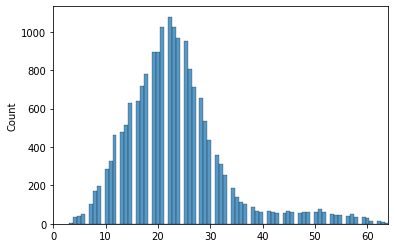

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(n_tokens)
plt.xlim([0, 64]);

### Define a custom `BERT_Dataset` class to process datasets

`Bert_Dataset` class assists at the encoding process of the datasets and enabling also the construction of the respective dataloaders

In [16]:
from transformers import BertTokenizerFast, BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

### BERT_Dataset class aims to store the encoded datasets
class BERT_Dataset():
  def __init__(self, dataset, tokenizer, max_len=64):
    # list of tweets
    self.tweets = dataset.cleaned_tweet.values
    # tensor of labels
    self.labels = torch.tensor(dataset.label.values)
    # tokenization model
    self.tokenizer = tokenizer
    # maximum len of sentances
    self.max_len = max_len
    self.input_ids, self.attention_masks = self.encoding()
  
  ## returns the content, input_ids, attention_mask and label of an encoded tweet
  def __getitem__(self, idx):
    return self.tweets[idx], self.input_ids[idx], self.attention_masks[idx], self.labels[idx]
  
  ## returns the size of dataset
  def __len__(self):
    return len(self.tweets)

  ## encodes dataset using `BertTokenizerFast`
  def encoding(self):
    input_ids = []
    attention_masks = []
    for entry in self.tweets:
      encoding = self.tokenizer.encode_plus(entry, 
                                            add_special_tokens=True, 
                                            max_length=self.max_len, 
                                            return_token_type_ids=False, 
                                            padding='max_length', 
                                            truncation = True,
                                            # pad_to_max_length=True,
                                            return_attention_mask=True)
      
      input_ids.append(encoding['input_ids'])
      attention_masks.append(encoding['attention_mask'])
    return torch.tensor(input_ids), torch.tensor(attention_masks)
  
  ## returns a dataloader to process the dataset in batches
  def get_DataLoader(self, batch_size=16, sampler='RandomSampler'):
    # creat a tensor of target values
    tensor = TensorDataset(self.input_ids, self.attention_masks, self.labels)
    # choose sampler and return dataloader
    if sampler == 'RandomSampler':
      return DataLoader(tensor, sampler=RandomSampler(tensor), batch_size=batch_size)
    elif sampler == 'SequentialSampler':
      return DataLoader(tensor, sampler=SequentialSampler(tensor), batch_size=batch_size)
    else:
      return DataLoader(tensor, batch_size=batch_size, shuffle=True)

### Parse datasets

In [17]:
train_data = BERT_Dataset(dataset=df_train, tokenizer=tokenizer)
test_data = BERT_Dataset(dataset=df_test, tokenizer=tokenizer)

In [18]:
sample = train_data[0]
print(sample[0])
print(tokenizer.convert_ids_to_tokens(sample[1].squeeze()))

Sip N Shop Come thru right now Marjais PopularNobodies MMR Marjais SipNShop 
['[CLS]', 'sip', 'n', 'shop', 'come', 'thru', 'right', 'now', 'mar', '##ja', '##is', 'popular', '##nob', '##odies', 'mm', '##r', 'mar', '##ja', '##is', 'sip', '##ns', '##hop', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


## Classification

### Defining a custom Classifier

The class `BertClassifier` utilizes a simple Feed Forward Network (from Assignment 2) for classification and a Bert Model (as defined above) to extract the last hidden layer of the `[CLS]` token.

In [19]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, hidden_size, output_dim, dropout_prob, freeze_bert=False, input_dim=768):
        super(BertClassifier, self).__init__()
        # input dimensions (768)
        self.input_dim = input_dim
        # hidden dimensions (50)
        self.hidden_size = hidden_size
        # output dimensions (3)
        self.output_dim = output_dim
        # loading pre trained bert
        self.bert = BertModel.from_pretrained(BERT_MODEL)
        # declare a simple feed forward network for classification
        self.classifier = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(self.hidden_size, self.output_dim)
        )
        # `set freeze_bert` to False to fine tune the pretrained model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # get bert predictions
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # retrieve the last hidden state
        h_n = out[0][:, 0, :]
        # get the final logits
        out = self.classifier(h_n)
        # retun logits
        return out

### Defining a class to perform experiments

The `Experiments` class (implemented in all previous Assignments) encapsulates the training, evaluation and score reporting methods of a specific model.

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
import scikitplot as skplt
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Experiments():
  def __init__(self, model, epochs, criterion, optimizer, train_data, test_data):
    # bert model
    self.model = model
    # train parameters
    self.epochs = epochs
    self.criterion = criterion
    self.optimizer = optimizer
    # datasets
    self.train_dataset = train_data
    self.test_dataset = test_data
    # create dataloaders to process datasets in batches
    self.train_dataloader = train_data.get_DataLoader(sampler='RandomSampler')
    self.test_dataloader = test_data.get_DataLoader(sampler='SequentialSampler')
    # stats
    self.train_scores = {'loss':[], 'accuracy':[], 'predicted_labels':[]}
    self.val_scores = {'loss':[], 'accuracy':[], 'predicted_labels':[]}

  def get_pred_labels(self, out):
    # apply softmax before obtaining results
    soft_pred = torch.log_softmax(out, dim=1)
    # get prediction labels
    _, pred = torch.max(soft_pred, dim=1)
    return pred
  
  def compute_accuracy(self, labels, pred):
    correct = (pred == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy
  
  def compute_scores(self, accuracy, loss, n, pred, contrainer):
    contrainer['accuracy'].append(accuracy/n)
    contrainer['loss'].append(loss/n)
    contrainer['predicted_labels'].append(np.concatenate(pred).ravel().tolist())

  def get_train_scores(self):
    return self.train_scores
  
  def get_validation_scores(self):
    return self.val_scores
  
  def epoch_report(self, epoch, labels):
      print('====')
      print('Classification report on validation set')
      print('====')
      print(classification_report(labels, self.val_scores['predicted_labels'][epoch-1]))

  def plot_roc_curves(self):
    pred = []
    # perform a final evaluation loop to get the prediction logits
    for _, (ids, att_mask, _) in enumerate(self.test_dataloader):
      ids = ids.to(device)
      att_mask = att_mask.to(device)
      # get predictions
      with torch.no_grad():
        out = self.model.forward(ids, att_mask)
      pred.append(out)
    pred = torch.cat(pred, dim=0)
    # apply softmax
    soft_pred = torch.log_softmax(pred, dim=1).cpu().numpy()
    # output the roc curve given the test labels and predicted logits
    skplt.metrics.plot_roc(self.test_dataset.labels, soft_pred)

  def plot_loss_curves(self):
    plt.figure(figsize=(10,10))
    plt.title("Training / Validation Loss Curves")
    plt.plot(self.train_scores['loss'],'-b')
    plt.plot(self.val_scores['loss'],'-g')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(('Training','Validation'), loc='upper right', fontsize='x-large')
    plt.show()

  def run(self):
    # iterate for each epoch
    for epoch in range(self.epochs):
      # train mode
      self.model.train()
      train_loss = 0
      train_pred = []
      train_accuracy = 0
      # train per batches
      for idx, (ids, att_mask, y) in enumerate(self.train_dataloader):
        ids = ids.to(device)
        att_mask = att_mask.to(device)
        y = y.to(device)
        # forward pass
        out = self.model.forward(ids, att_mask)
        loss = self.criterion(out, y)
        # backward pass and update
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
        # stats
        batch_pred = self.get_pred_labels(out)
        train_accuracy += self.compute_accuracy(y, batch_pred)
        train_loss += loss.item()
        train_pred.append(batch_pred.cpu().numpy())
      # compute final stats
      self.compute_scores(train_accuracy, train_loss, len(self.train_dataloader), train_pred, self.train_scores)

      # predict on validation set
      with torch.no_grad():
        # evaluation mode
        self.model.eval()
        val_loss = 0
        val_pred = []
        val_accuracy = 0
        # evaluate per batches
        for idx, (ids_val, att_mask_val, y_val) in enumerate(self.test_dataloader):
          ids_val = ids_val.to(device)
          att_mask_val = att_mask_val.to(device)
          y_val = y_val.to(device)
          # get predictions
          out = self.model.forward(ids_val, att_mask_val)
          loss = self.criterion(out, y_val)
          # stats
          batch_pred = self.get_pred_labels(out)
          val_accuracy += self.compute_accuracy(y_val, batch_pred)
          val_loss += loss.item()
          val_pred.append(batch_pred.cpu().numpy())
        # compute final stats
        self.compute_scores(val_accuracy, val_loss, len(self.test_dataloader), val_pred, self.val_scores)

        # verbose
        print('Epoch: {}. Train Loss: {}. Val Loss: {}. Train Accuracy: {}. Val Accuracy: {}.'.format(epoch+1, (train_loss/len(self.train_dataloader)), (val_loss/len(self.test_dataloader)), (train_accuracy/len(self.train_dataloader)), (val_accuracy/len(self.test_dataloader))))

### Experiments

In [21]:
# Define Classifiers parameters
input_dim = 768
output_dim = 3
hidden_dim = 50

#### Grid Search

In this section, a Grid Search algorithm was performed to determine the "best" parameters.

To that extent, the parameters and the respective values examined are the following:


*   Number of epochs: 2, 3, 4
*   Dropout Probability: 0.3, 0.5, 0.7
*   Learning Rate: 5e-5, 3e-5, 2e-5



In [22]:
"""
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.utils import class_weight
import numpy as np

n_epochs = [2, 3, 4]
dropout_probs = [0.3, 0.5, 0.7]
learning_rates = [5e-5, 3e-5, 2e-5]

for epochs in n_epochs:
  for dp in dropout_probs:
    for lr in learning_rates:
      model = BertClassifier(50, 3, dp)
      model = model.to(device)

      class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df_train.label), y=df_train.label)
      class_weights = torch.tensor(class_weights,dtype=torch.float)

      criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
      criterion = criterion.to(device)

      optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)

      exp = Experiments(model, epochs, criterion, optimizer, train_data, test_data)
      exp.run()
      exp.epoch_report(epochs, test_data.labels, 'val')
"""

"\nfrom transformers import AdamW, get_linear_schedule_with_warmup\nfrom torch.optim import AdamW\nfrom sklearn.utils import class_weight\nimport numpy as np\n\nn_epochs = [2, 3, 4]\ndropout_probs = [0.3, 0.5, 0.7]\nlearning_rates = [5e-5, 3e-5, 2e-5]\n\nfor epochs in n_epochs:\n  for dp in dropout_probs:\n    for lr in learning_rates:\n      model = BertClassifier(50, 3, dp)\n      model = model.to(device)\n\n      class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df_train.label), y=df_train.label)\n      class_weights = torch.tensor(class_weights,dtype=torch.float)\n\n      criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')\n      criterion = criterion.to(device)\n\n      optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)\n\n      exp = Experiments(model, epochs, criterion, optimizer, train_data, test_data)\n      exp.run()\n      exp.epoch_report(epochs, test_data.labels, 'val')\n"

#### Best Model

The best model's parameters are the following:


*   Number of epochs: 2
*   Dropout Probability: 0.5
*   Learning Rate: 3e-5


In [23]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.utils import class_weight
import numpy as np

n_epochs = 2
dropout = 0.5
learning_rate = 3e-5


model = BertClassifier(hidden_dim, output_dim, dropout)
model = model.to(device)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df_train.label), y=df_train.label)
class_weights = torch.tensor(class_weights,dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
criterion = criterion.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
exp = Experiments(model, n_epochs, criterion, optimizer, train_data, test_data)
exp.run()

Epoch: 1. Train Loss: 0.8046478718907029. Val Loss: 0.6631965033866308. Train Accuracy: 0.6599724888801575. Val Accuracy: 0.7139859795570374.
Epoch: 2. Train Loss: 0.5817759794307066. Val Loss: 0.6606325319596937. Train Accuracy: 0.7722097039222717. Val Accuracy: 0.7632867097854614.
Epoch: 3. Train Loss: 0.4068738250052547. Val Loss: 0.720735942775553. Train Accuracy: 0.8481606245040894. Val Accuracy: 0.7361013889312744.


In [25]:
# Classification Results after running for 1 epoch
exp.epoch_report(1, test_data.labels)

====
Classification report on validation set
====
              precision    recall  f1-score   support

           0       0.91      0.66      0.76      1065
           1       0.45      0.75      0.56       296
           2       0.70      0.77      0.73       921

    accuracy                           0.71      2282
   macro avg       0.68      0.72      0.68      2282
weighted avg       0.76      0.71      0.72      2282



In [26]:
# Classification Results after running for 2 epochs
exp.epoch_report(2, test_data.labels)

====
Classification report on validation set
====
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1065
           1       0.62      0.58      0.60       296
           2       0.72      0.81      0.76       921

    accuracy                           0.76      2282
   macro avg       0.73      0.72      0.72      2282
weighted avg       0.77      0.76      0.76      2282



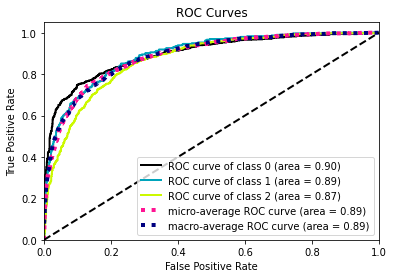

In [28]:
# plor roc curves on validation set
exp.plot_roc_curves()